# Equilibrium examples
## Inverse Solve and Forward Solve for Grad-Shafranov Equilibria
This example notebook shows how to solve for different flavours of Grad-Shafranov equilibria: inverse and forward solve for diverted configurations; and inverse and forward solve for limited plasmas. The profiles chosen for this notebook follow the notation of Jeon (2015) for the toroidal plasma current:
$$j_{pl}=\left( 1-\psi_{n}^{\alpha_m} \right)^{\alpha_n}\left( \lambda\beta_{0}R/R_{0}+(1-\beta_{0})\lambda R_{0}/R \right) $$ 

The first contribution is the pressure support $p^{\prime}(\psi_{n})$, the second one is the toroidal-field support $f'f.$
The examples are given for a parameterisation of the plasma pressure in terms of $p_a,$ the pressure on axis, and then again for a "BetapIp" profile object, with a proxy to the poloidal beta of the plasma. The "Lao profiles" would correspond to $\alpha_m=2$ and $\alpha_n=1.$

__NB__ In this notebook, the necessary imports are made as soon as they are needed, to illustrate what they are responsible for, so you will find some "import" statements in cells further down.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sys
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time
import os

In [2]:
import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"


In [3]:
import freegs
from freegs.plotting import plotConstraints
from freegs.critical import find_critical
from freegsnke import machine_config
from freegsnke import build_machine
from freegsnke import faster_shape
from freegsnke.jtor_update import ConstrainPaxisIp
from freegsnke import GSstaticsolver

%load_ext autoreload
%autoreload 2

## 1. Create the machine object.

First, identify files containing the machine description. FreeGSNKE requires the user to define the following environment variables:

ACTIVE_COILS_PATH , PASSIVE_COILS_PATH , WALL_PATH , LIMITER_PATH . These define the machine geometry and properties. 

Right now, they are saved as pickle dictionaries, mostly for convenience because the active-coil dictionary contains a lot of info about the coil windings.

FreeGSNKE uses some of the base functionality provided by FreeGS to build "tokamak' machine objects, and the FreeGS public repository shows some examples. The approach chosen in FreeGSNKE allows hte user to upload config files with the machine description without having to write them in FreeGS syntax. You can have a look at the function "build_machine" to see what dictionary structure it expects and how it transforms it into a machine description.

In [4]:
# Create the machine.

# First, identify files containing the machine description.
# freeGSNKE requires the user to define the following environment variables 
# ACTIVE_COILS_PATH
# PASSIVE_COILS_PATH
# WALL_PATH
# LIMITER_PATH
# These define the machine geometry and properties.
# import os
# os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils.pickle"
# os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
# os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
# os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"

# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()



## 2. Inverse solve and forward solve for a diverted equilibrium

We start with an equilibrium where the plasma is entirely contained by its last-closed-flux-surface (LCFS), which goes through at least one of the X-points (saddle-points in $\psi$) and does not intersect the tokamak's limiter. We start with an _inverse_ solve, where we specify a few points that must lie on the same LCFS, and the coil currents are then determined together with $\psi(R,Z)$. We then show how to do a _forward_ solve, for which we need to specify the currents instead, and the profile $\psi(R,Z)$ is to be determined. The invere solve alternates a Picard iteration ($\psi(R,Z) \mapsto (\Delta^*)^{-1}\psi(R,Z)$) with one adjustment in the coil currents such that the resulting LCFS is as close as possible to the prescribed constraints, iterating until convergence. The forward solver uses the Newton-Krylov implementation described by Amorisco et al (2024) in _Physics of Plasmas_.

### Inverse-solve of an equilibrium , with "PaxisIp" profile object
We start by specifying some parameters of the plasma and of the domain of integration. In the cell below, the first line specifies the domain boundaries and meshes in R and Z, the second line specifes the plasma pressure on-axis (in Pascal), total plasma current (in Amperes), and vacuum toroidal field strength $f_{vac}=B_{\phi}R.$ The third line fixes the exponents of p' and f'f. Note that, while the "equilibrium" object is instantiated directly through FreeGS, the internal "PaxisIp" object is instantiated through FreeGSNKE. This is because, depending on the version of FreeGS that you use, there may be a more efficient way of computing and sufacing some variables in that profile class. FreeGSNKE has an internal check that can cope with that. Alternatively, you can also use the object as provided by FreeGS instead.

In [5]:
Rmin0=0.1 ; Rmax0=2.0 ; Zmin0=-2.2 ; Zmax0=2.2 ; NX=65 ; NY=129 ; 
p_a = 8.1e3 ; I_p=6.2e5 ; f_vac = 0.5 ; 
am0=1.8 ; an0=1.2;

In [6]:

# Creates equilibrium object and initializes it with 
# a "good" solution
# plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed 
                        Rmin=Rmin0, Rmax=Rmax0,    # Radial domain
                        Zmin=Zmin0, Zmax=Zmax0,   # Height range
                        #grid resolution can be changed
                        nx=NX, ny=NY, # Number of grid points
                        # psi=plasma_psi[::2,:])   
                        )

# Sets desired plasma properties for the 'starting equilibrium'
# Use one between ConstrainPaxisIp or ConstrainBetapIp
# values can be changed
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(eq, tokamak.limiter,
                            p_a, # Plasma pressure on axis [Pascals]
                            I_p, # Plasma current [Amps]
                            f_vac, # vacuum f = R*Bt
                            alpha_m = am0,
                            alpha_n = an0)
# from freegsnke.jtor_update import ConstrainBetapIp
# profiles = ConstrainBetapIp(eq, tokamak.limiter,
#                             0.2, # betap proxy
#                             6.2e5, # Plasma current [Amps]
#                             0.5, # vacuum f = R*Bt
#                             alpha_m = 1.8,
#                             alpha_n = 1.2)       

Now we specify a few constraints on the X-point position(s) and on some _isoflux_ points where $\psi(R,Z)$ should be the same.

This is identical to the FreeGS syntax, and we pass the instantiated equilibrium above the FreeGS "constrain" object.

In [7]:

# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.6
Zx = 1.1

Rmid = 1.41   # Outboard midplane
Rin = 0.36  # Inboard midplane

xpoints = [(Rx, -Zx-.01),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
    
           # Link inner and outer midplane locations
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),

           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]


Now we need to link the constraints above to the equilibrium for which we want to solve. Since the problem is often underconstrained, we also specify the quadratic penalty ("gamma" below) that we want to set on the coil currents. In our case, this penalty also guides the solution towards one where only the active coils have non-zero currents. You can play around with different values of "gamma" to see whether (and how) the converged solution departs from the desired constraints.

In FreeGS, whenever an equilibrium file is imported, an automatic pass of inverse-solve is made using the $\psi(R,Z)$ map as an array of $NX\times NY$ constraints. In that case, the problem has $\mathcal{O}(10^4)$ constraints and $\mathcal{O}(10^3)$ unknowns, so the passive filaments may be assigned non-zero currents.

In [8]:

eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=5e-7, 
                                     isoflux=isoflux
                                    )
constrain(eq)       

Now we set the solenoid current to a high value, say 15000 Amperes, do one inverse-solve, and then refine it with one NEwton-Krylov solve once the inverse-solve has converged on the required coil currents. 
The next cell will take a bit to run, because the "NKGSsolver" object must compute a few things from the domain properties of the equilibrium.

__NB__ If you only change the properties of the equilibrium, but not the integration domain or the mesh, you don't need to instantiate a new NKGSsolver: once it is instantiated, if you want to play with different equilibria over the same domain and mesh, you just need to call the "solve()" method from the NK instance below on the new equilibria that you want it to solve for.

In [9]:
from freegsnke import GSstaticsolver
NK = GSstaticsolver.NKGSsolver(eq)    

In [10]:
eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False
eq.tokamak['Solenoid'].current = 15000
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)               
# eq.tokamak['Solenoid'].current = 40000
# freegs.solve(eq,          # The equilibrium to adjust
#              profiles,    # The plasma profiles
#              constrain,   # Plasma control constraints
#              show=False,
#              rtol=3e-3)             

Text(0.5, 1.0, 'q profile')

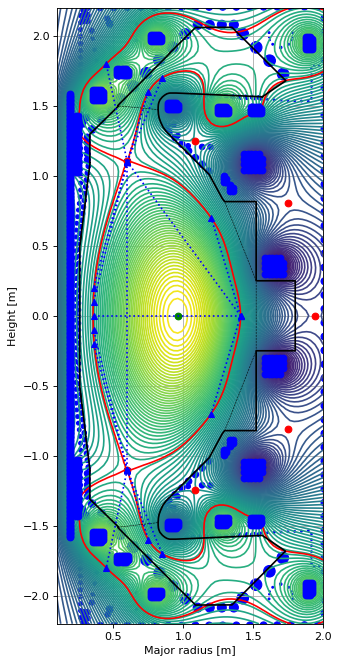

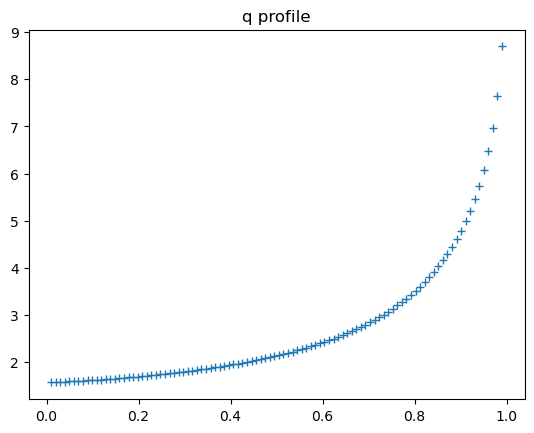

In [11]:
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

qprof = eq.q()
plt.figure()
plt.plot(qprof[0], qprof[1], '+')
plt.title('q profile')

Text(0.5, 1.0, 'q profile')

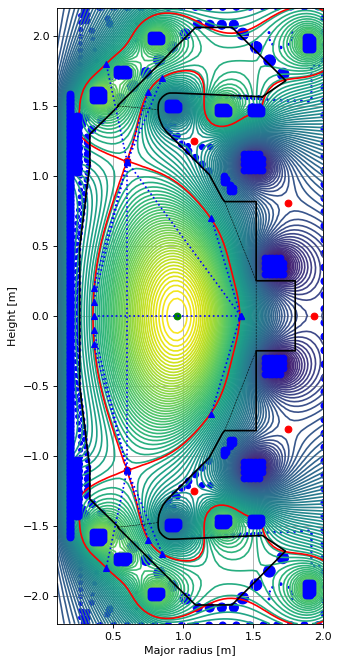

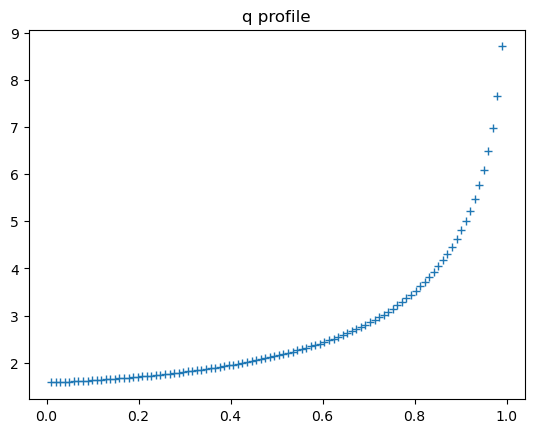

In [12]:
NK.solve(eq, profiles, target_relative_tolerance=1e-8)
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

qprof = eq.q()
plt.figure()
plt.plot(qprof[0], qprof[1], '+')
plt.title('q profile')

In [13]:
tcurrent_values={}
for coil in eq.tokamak.coils:
    tcurrent_values[coil[0]] = eq.tokamak[coil[0]].current

In [14]:
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=tcurrent_values,file=f)

### Forward-solve from scratch
In the cell above, we have started with some X-pont and isoflux constraints, done an inverse-solve, and then refined with a forward-solve once the inverse-solve has converged on a set of currents for the active coils. But what if we are given a dictionary of coil currents, and we need to find the corresponding Grad-Shafranov equilibrium, without any X-point and isoflux constraints provided? The cell below shoes how it can be done using the NK GS static solver, on some coil currents loaded by a pickle dictionary.

Note that we are re-instanting the NKGSsolve object, but you don't need to do it if you are running this notebook from above. If you already have it from the previous cells, you can comment it out.

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

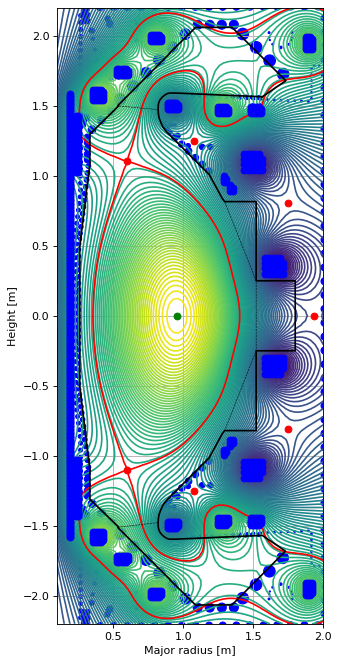

In [15]:
# Forward-solve of an equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
# Set initial equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# Instantiate freeGSNKE static GS solver
from freegsnke import GSstaticsolver
# This requires use of the equilibrium itself to inform the solver of the domain and grid properties:
NK = GSstaticsolver.NKGSsolver(eq)
# Solve the forward GS problem corresponding to the tokamak metal currents set above and the requested profile properties
NK.solve(# The Equilibrium object sets the currents 
         eq, 
         # The profile sets the desired plasma properties
         profiles,
         # The relative tolerance set for convergence
         target_relative_tolerance=1e-8,
         verbose=1)

# Plot the equilibrium
# As in freeGS, the full black line is the tokamak.wall.
# In addition, the thin black dotted line shows the tokamak.limiter,
# i.e. the border of the region where the plasma is allowed to be.
# The limiter is passed to the equilibrium object by the profile object during the NK.solve call. 
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)



## 3. Limited Equilibrium
In this case, the plasma "touches" the limiter of the tokamak and is confined by the solid structures of the vessel. The LCFS is the farthest closed contour from the magnetic axis that just barely touches the wall.

In [16]:
Rmin0=0.1 ; Rmax0=2.0 ; Zmin0=-2.2 ; Zmax0=2.2 ; NX=65 ; NY=129 ; 
p_a = 8.1e3 ; I_p=6.2e5 ; f_vac = 0.5 ; 
am0=1.8 ; an0=1.2;

In [17]:

# Creates equilibrium object and initializes it with 
# a "good" solution
# plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed 
                        Rmin=Rmin0, Rmax=Rmax0,    # Radial domain
                        Zmin=Zmin0, Zmax=Zmax0,   # Height range
                        #grid resolution can be changed
                        nx=NX, ny=NY, # Number of grid points
                        # psi=plasma_psi[::2,:])   
                        )



# Sets desired plasma properties for the 'starting equilibrium'
# Use one between ConstrainPaxisIp or ConstrainBetapIp
# values can be changed
# from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(eq, tokamak.limiter,
                            p_a, # Plasma pressure on axis [Pascals]
                            I_p, # Plasma current [Amps]
                            f_vac, # vacuum f = R*Bt
                            alpha_m = am0,
                            alpha_n = an0)
# from freegsnke.jtor_update import ConstrainBetapIp
# profiles = ConstrainBetapIp(eq, tokamak.limiter,
#                             betap, # betap proxy, 0.2 here
#                             I_p, # Plasma current [Amps]
#                             f_vac, # vacuum f = R*Bt
#                             alpha_m = 1.8,
#                             alpha_n = 1.2)

In [18]:

# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.45
Zx = 1.18

Rmid = 1.4   # Outboard midplane
Rin = 0.28  # Inboard midplane

xpoints = [(Rx, -Zx-.01),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
    
           # Link inner and outer midplane locations
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),

           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]


In [19]:
eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=5e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)
                                    
from freegsnke import GSstaticsolver
NK = GSstaticsolver.NKGSsolver(eq)

Now we set the solenoid current to 40000 Amperes, in two stages to guide the constrained solver so that it still converges within some reasonable tolerance. With this example of machine and plasma configuration, due to the stray magnetic field of the solenoid, solenoid currents above $\approx$20000 Amperes result in solutions where the plasma is squeezed onto the central column.

/Users/adriano.agnello/Library/CloudStorage/OneDrive-ScienceandTechnologyFacilitiesCouncil/pythonstuff/freegswork/freegsnke_2024/freegsfast/freegs/critical.py:693: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")


Text(0.5, 1.0, 'q profile')

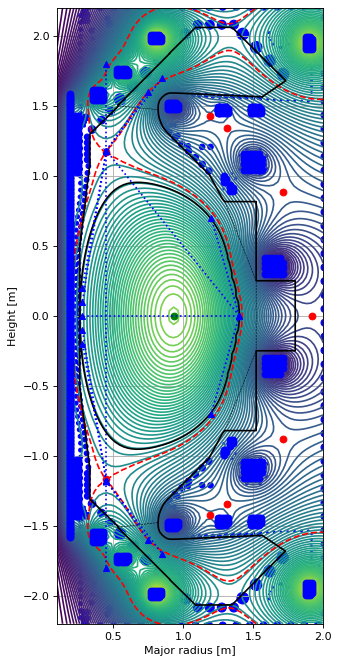

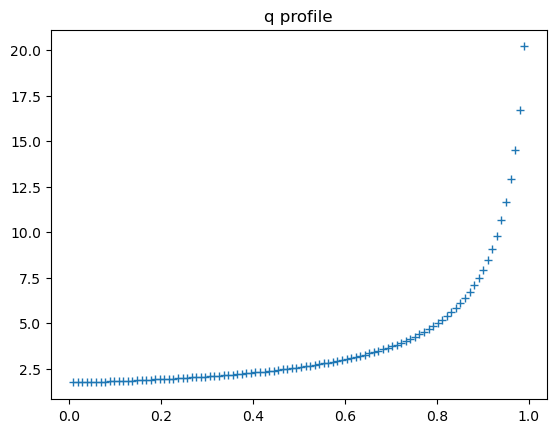

In [20]:
eq.tokamak['P6'].current = 0.1
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False
eq.tokamak['Solenoid'].current = 15000
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)

eq.tokamak['Solenoid'].current = 40000
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)

NK.solve(eq, profiles, target_relative_tolerance=1e-8)
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

qprof = eq.q()
plt.figure()
plt.plot(qprof[0], qprof[1], '+')
plt.title('q profile')

Like we did for the diverted plasma, we save the coil currents to a pickle dictionary, which is used below to forward-solve the GS equilibrium from scratch, without starting with isoflux or X-point constraints.

In [21]:
tcurrent_values={}
for coil in eq.tokamak.coils:
    tcurrent_values[coil[0]] = eq.tokamak[coil[0]].current

In [22]:
import pickle
with open('simple_limited_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=tcurrent_values,file=f)

### Forward-solve from scratch, for a limited plasma, with currents from dictionary
The following is very similar to the example above on the diverted plasma. If you want to only run the forward-solve, you should make sure that you have a suitable set of coil currents already saved somewhere.

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

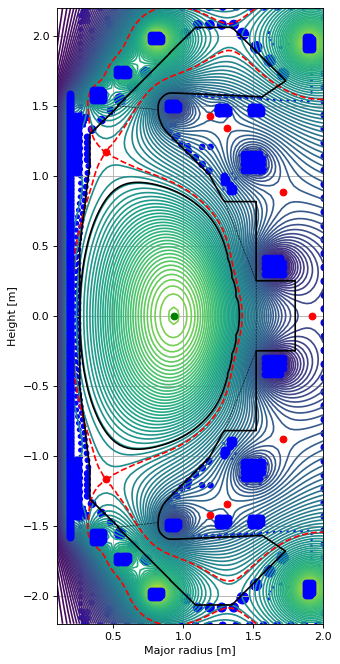

In [23]:
### Forward-solve from scratch, for a limited plasma, with currents from dictionary
# Forward-solve of an equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
# Set initial equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
import pickle
with open('simple_limited_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# Instantiate freeGSNKE static GS solver
from freegsnke import GSstaticsolver
# This requires use of the equilibrium itself to inform the solver of the domain and grid properties:
NK = GSstaticsolver.NKGSsolver(eq)
# Solve the forward GS problem corresponding to the tokamak metal currents set above and the requested profile properties
NK.solve(# The Equilibrium object sets the currents 
         eq, 
         # The profile sets the desired plasma properties
         profiles,
         # The relative tolerance set for convergence
         target_relative_tolerance=1e-8,
         verbose=1)

# Plot the equilibrium
# As in freeGS, the full black line is the tokamak.wall.
# In addition, the thin black dotted line shows the tokamak.limiter,
# i.e. the border of the region where the plasma is allowed to be.
# The limiter is passed to the equilibrium object by the profile object during the NK.solve call. 
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)

## 4. The same as above, but with "BetapIp" internal profile class
In the "BetapIp" profile class, instead of prescribing $p_a,$ we seek to match a proxy for the poloidal beta parameter, in particular the prefactors $\lambda$ and $\beta_0$ of the p' and f'f functions are adjusted to match a given value for $I_p$ and a given value of 
$$ \tilde{\beta}_p = \frac{8\pi}{\mu_0 I_p^2}   \int p(R,Z)\mathrm{d}R\mathrm{d}Z  $$ 
following Jeon (2015, arXiv:1503.03135). 

In [24]:
# Create the machine.

# First, identify files containing the machine description.
# freeGSNKE requires the user to define the following environment variables 
# ACTIVE_COILS_PATH
# PASSIVE_COILS_PATH
# WALL_PATH
# LIMITER_PATH
# These define the machine geometry and properties.
import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"

# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

### Diverted "BetapIp" equilibrium, inverse solve and forward solve

In [25]:
Rmin0=0.1 ; Rmax0=2.0 ; Zmin0=-2.2 ; Zmax0=2.2 ; NX=65 ; NY=129 ; 
betap0 = 0.2 ; I_p=6.2e5 ; f_vac = 0.5 ; 
am0=1.8 ; an0=1.2;

In [26]:

# Creates equilibrium object and initializes it with 
# a "good" solution
# plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed 
                        Rmin=Rmin0, Rmax=Rmax0,    # Radial domain
                        Zmin=Zmin0, Zmax=Zmax0,   # Height range
                        #grid resolution can be changed
                        nx=NX, ny=NY, # Number of grid points
                        # psi=plasma_psi[::2,:])   
                        )

# Sets desired plasma properties for the 'starting equilibrium'
# Use one between ConstrainPaxisIp or ConstrainBetapIp
# values can be changed
# from freegsnke.jtor_update import ConstrainPaxisIp
# profiles = ConstrainPaxisIp(eq, tokamak.limiter,
#                             p_a, # Plasma pressure on axis [Pascals]
#                             I_p, # Plasma current [Amps]
#                             f_vac, # vacuum f = R*Bt
#                             alpha_m = am0,
#                             alpha_n = an0)
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(eq, tokamak.limiter,
                            betap0, # betap proxy
                            I_p, # Plasma current [Amps]
                            f_vac, # vacuum f = R*Bt
                            alpha_m = 1.8,
                            alpha_n = 1.2)

In [27]:

# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.6
Zx = 1.1

Rmid = 1.41   # Outboard midplane
Rin = 0.36  # Inboard midplane

xpoints = [(Rx, -Zx-.01),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
    
           # Link inner and outer midplane locations
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),

           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]

eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=5e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)

In [28]:
from freegsnke import GSstaticsolver
NK = GSstaticsolver.NKGSsolver(eq)

Text(0.5, 1.0, 'q profile')

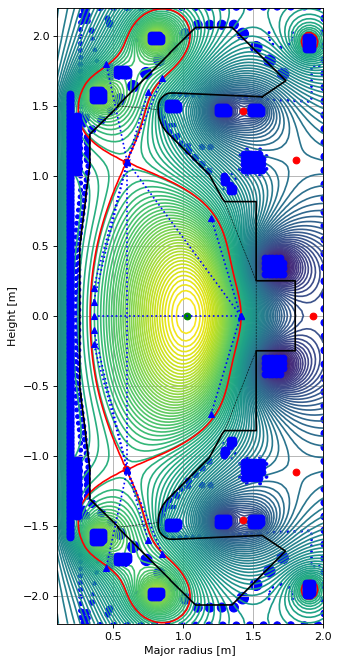

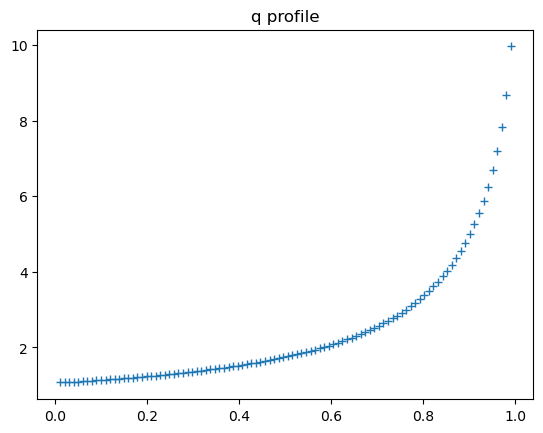

In [29]:
eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False
eq.tokamak['Solenoid'].current = 15000
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)
# eq.tokamak['Solenoid'].current = 40000
# freegs.solve(eq,          # The equilibrium to adjust
#              profiles,    # The plasma profiles
#              constrain,   # Plasma control constraints
#              show=False,
#              rtol=3e-3)
             
NK.solve(eq, profiles, target_relative_tolerance=1e-8)
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

qprof = eq.q()
plt.figure()
plt.plot(qprof[0], qprof[1], '+')
plt.title('q profile')

In [30]:
tcurrent_values={}
for coil in eq.tokamak.coils:
    tcurrent_values[coil[0]] = eq.tokamak[coil[0]].current

import pickle
with open('simple_diverted_currents_BetapIp.pk', 'wb') as f:
    pickle.dump(obj=tcurrent_values,file=f)

### Diverted "BetapIp", forward-solve from scratch with coil currents from file dict

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

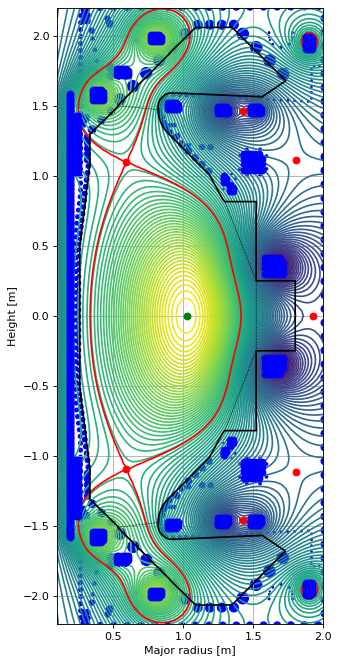

In [31]:
# Forward-solve of an equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
# Set initial equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
import pickle
with open('simple_diverted_currents_BetapIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# Instantiate freeGSNKE static GS solver
from freegsnke import GSstaticsolver
# This requires use of the equilibrium itself to inform the solver of the domain and grid properties:
NK = GSstaticsolver.NKGSsolver(eq)
# Solve the forward GS problem corresponding to the tokamak metal currents set above and the requested profile properties
NK.solve(# The Equilibrium object sets the currents 
         eq, 
         # The profile sets the desired plasma properties
         profiles,
         # The relative tolerance set for convergence
         target_relative_tolerance=1e-8,
         verbose=1)

# Plot the equilibrium
# As in freeGS, the full black line is the tokamak.wall.
# In addition, the thin black dotted line shows the tokamak.limiter,
# i.e. the border of the region where the plasma is allowed to be.
# The limiter is passed to the equilibrium object by the profile object during the NK.solve call. 
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)